# Introduction

The purpose of this project is to analyze the results of governance proposals for SushiSwap. We seek to determine a couple of key aspects:
- The percentage of Sushi proposals that pass
- If those proposals present any patterns

**Data Source**<br>
SushiSwap uses the Snapsot platform to manage governance proposal voting, so we can use the same platform to extract the data about all of the proposals.
- **SushiSwap Snapshot** - https://snapshot.org/#/sushigov.eth
- raw **proposal data** is in the `sushi_proposals.json` file
- the full **queries used** can be found in the `snapshotQuery_sushi.gql` file

## Setting up the environment
1. Import modules

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

2. Set dataframe and graph options

In [3]:
pd.set_option('display.max_colwidth', 20)
sns.set_style('darkgrid')

# Data

## Loading the data
The raw data will be imported into a `Pandas Dataframe` so we can use Python to handle and analyze it.

- `id`(text): unique identifier for proposal
- `title`(text): the title of the proposal
- `choices`(list): contains all of the given voting options
- `start`(number): unix timestamp of starting date
- `end`(number): unix timestamp of ending date
- `snapshot`(number): block that locks the state of community members who are able to vote
- `author`(text): wallet address of the person who posted the proposal
- `votes`(number): total number of votes casted
- `scores`(list): contains the score for each available choice
- `scores_total`(number): total voting power aka 'SUSHIPOWAH'

In order to make the data more readable and interpretable, the `start` and `end` columns will be converted to ISO date and time formats.

In addition to these columns, we will insert two more:
- `num_choices`(number): count of options in the choices list
- `passed`(bool): the scores_total passed the 20k SUSHIPOWAH threshold for a successful proposal
- `is_admin`(bool): whether the author of the proposal is currently an admin

In [24]:
df = pd.read_json('sushi_proposals.json')
df.start = df.start.apply(lambda x: datetime.datetime.fromtimestamp(x).isoformat())
df.end = df.end.apply(lambda x: datetime.datetime.fromtimestamp(x).isoformat())

admin = ['0x4bb4c1B0745ef7B4642fEECcd0740deC417ca0a0','0xb4A3f907ec1611F22543219AE9Bb33ec5E96e116','0x1C0Aa8cCD568d90d61659F060D1bFb1e6f855A20','0x285b7EEa81a5B66B62e7276a24c1e0F83F7409c1']
df['is_admin'] = df.author.isin(admin)
df['num_choices'] = df.choices.apply(lambda x: len(x))
df['passed'] = df.scores_total >= 2*10**4
df.head()

,id,title,choices,start,end,snapshot,author,votes,scores,scores_total,is_admin,num_choices,passed
0,0x3e8c549e82d973...,Fund Team to Onb...,"[Yes, LFFFFGG, M...",2021-11-18T13:00:00,2021-11-21T13:00:00,13632357,0xBd31D988151DE3...,202,[106049.23305496...,1.080705e+05,False,3,True
1,0x8315ab4c4ef397...,Collateralize SU...,[Collateralize T...,2021-11-10T19:00:00,2021-11-15T19:00:00,13589329,0x1C0Aa8cCD568d9...,1027,[6728695.2336487...,6.746548e+06,True,3,True
2,QmcwEVRfidkg5U8n...,Community-Enable...,"[Fund CEA, Nay]",2021-10-19T19:00:00,2021-10-23T22:00:00,13450939,0x1C0Aa8cCD568d9...,804,[3361810.2412042...,3.559517e+06,True,2,True
3,QmNT8bY7aJRFUMtf...,Multichain Expan...,"[Yay, Nay]",2021-08-13T07:00:00,2021-08-17T22:00:00,13012538,0x285b7EEa81a5B6...,1108,[12358627.302780...,1.668710e+07,True,2,True
4,QmfEqngSUDtZHgQf...,oSUSHI [SIGNAL],[Start the gauge...,2021-08-13T07:00:00,2021-08-17T22:00:00,13012525,0x285b7EEa81a5B6...,1089,[14266737.701309...,1.432602e+07,True,2,True


## Data exploration
We can start off by checking the shape of the dataset. The **244 rows** each represent an observation of a single proposal posted by SushiSwap on their Snapshot page.

The earliest proposal was posted on 26 Aug 2020, and the most recent one was posted on 18 Nov 2021.

In [5]:
print('dataset shape:',df.shape)
print('first proposal:', df.start.min())
print('latest proposal:', df.start.max())

dataset shape: (244, 12)
first proposal: 2020-08-26T15:00:00
latest proposal: 2021-11-18T13:00:00


When we look at the rest of the variables, we see that there have been proposals with **0 votes**, but the most voted proposal gathered **1627 votes**, a huge engagement if we consider that the 4th quartile starts with just 66. The scores_total, given its close relationship to the number of votes casted, tells a simmilar story.

For the number of choices, it naturally starts at a minumum of 2, but it then goes up to 20 choices. That number is a clear outlier, as over 75% of all proposals only have 3 options or less.

In [6]:
df[['votes','scores_total','num_choices']].describe()

,votes,scores_total,num_choices
count,244.000000,2.440000e+02,244.000000
mean,116.979508,1.331518e+06,2.774590
std,267.932327,4.108310e+06,1.864331
min,0.000000,0.000000e+00,2.000000
25%,4.000000,4.303730e+02,2.000000
50%,18.000000,6.987941e+03,2.000000
75%,66.500000,1.007082e+05,3.000000
max,1627.000000,2.603272e+07,20.000000


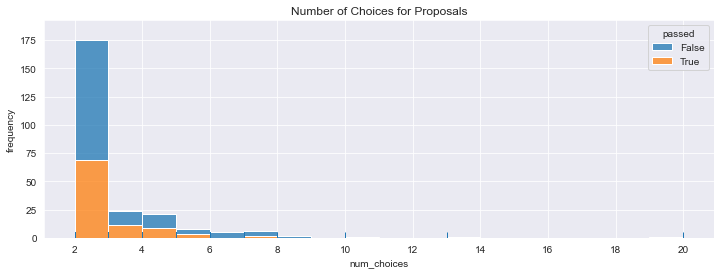

In [7]:
plt.figure(figsize=(12,4))

ax1 = plt.subplot()
sns.histplot(data=df, x='num_choices', hue='passed', multiple='stack', binwidth=1)
ax1.set_xticks(range(2,21,2))
plt.title('Number of Choices for Proposals')
plt.ylabel('frequency')
sns.rugplot(data=df, x='num_choices')

plt.show()

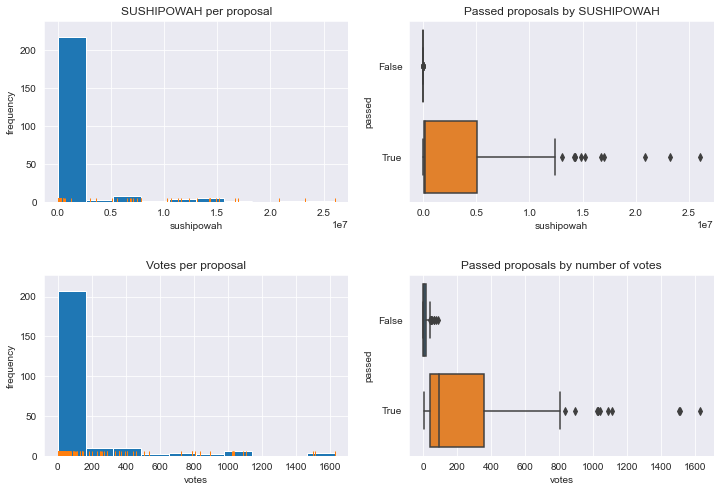

In [8]:
plt.figure(figsize=(12,8))

ax1 = plt.subplot(2,2,1)
plt.hist(x=df.scores_total)
plt.title('SUSHIPOWAH per proposal')
plt.xlabel('sushipowah')
plt.ylabel('frequency')
sns.rugplot(data=df, x='scores_total')

ax2 = plt.subplot(2,2,2)
sns.boxplot(data=df, x='scores_total', y='passed', orient='h')
plt.title('Passed proposals by SUSHIPOWAH')
plt.xlabel('sushipowah')

ax3 = plt.subplot(2,2,3)
plt.hist(x=df.votes)
plt.title('Votes per proposal')
plt.ylabel('frequency')
sns.rugplot(data=df, x='votes')

ax4 = plt.subplot(2,2,4)
sns.boxplot(data=df, x='votes', y='passed', orient='h')
plt.title('Passed proposals by number of votes')

plt.subplots_adjust(hspace=0.4)
plt.show()

# Analysis

## Percentage of passed proposals
We can now group all the data by the passed status to get a better understanding of how many proposals were actually successful. There have been only 97 successful proposals, meaning a success percentage of 39.75.

So let's see what makes a successful proposal.

In [11]:
status = df.groupby('passed').id.count().reset_index()
status.columns=['passed','proposals']
status['percentage'] = status.proposals/status.proposals.sum()*100
status

,passed,proposals,percentage
0,False,147,60.245902
1,True,97,39.754098


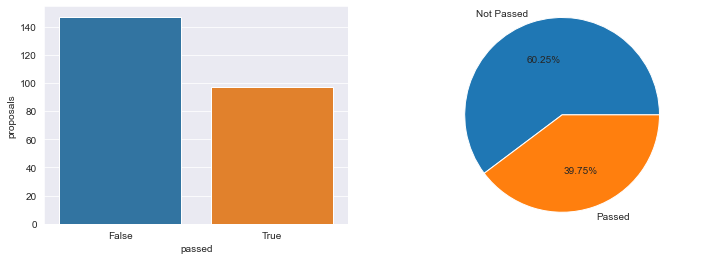

In [10]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1)
sns.barplot(data=passed, x='passed', y='proposals')

ax2 = plt.subplot(1,2,2)
plt.pie(passed.proposals, labels=['Not Passed','Passed'], autopct='%0.2f%%')
plt.axis('equal')
plt.show()

## Patterns of a successful proposal
For this section we will create a subset called `passed` that will contains only the lines of a passed proposal.

In [26]:
passed = df[df.passed]
passed.head()

,id,title,choices,start,end,snapshot,author,votes,scores,scores_total,is_admin,num_choices,passed
0,0x3e8c549e82d973...,Fund Team to Onb...,"[Yes, LFFFFGG, M...",2021-11-18T13:00:00,2021-11-21T13:00:00,13632357,0xBd31D988151DE3...,202,[106049.23305496...,1.080705e+05,False,3,True
1,0x8315ab4c4ef397...,Collateralize SU...,[Collateralize T...,2021-11-10T19:00:00,2021-11-15T19:00:00,13589329,0x1C0Aa8cCD568d9...,1027,[6728695.2336487...,6.746548e+06,True,3,True
2,QmcwEVRfidkg5U8n...,Community-Enable...,"[Fund CEA, Nay]",2021-10-19T19:00:00,2021-10-23T22:00:00,13450939,0x1C0Aa8cCD568d9...,804,[3361810.2412042...,3.559517e+06,True,2,True
3,QmNT8bY7aJRFUMtf...,Multichain Expan...,"[Yay, Nay]",2021-08-13T07:00:00,2021-08-17T22:00:00,13012538,0x285b7EEa81a5B6...,1108,[12358627.302780...,1.668710e+07,True,2,True
4,QmfEqngSUDtZHgQf...,oSUSHI [SIGNAL],[Start the gauge...,2021-08-13T07:00:00,2021-08-17T22:00:00,13012525,0x285b7EEa81a5B6...,1089,[14266737.701309...,1.432602e+07,True,2,True


### Admin posts
We can see in the table above that there have been 29 authors, but most of them have only got 2 successful proposals or less. But despite the difficulty this indicates, there are a couple of outliers with 11 and 46 successful proposals, so there must be something differentiating them from the rest.

In [33]:
authors = passed.groupby('author').agg({'scores_total':['sum','mean'],'votes':['sum','mean'], 'id':['count']}).reset_index()
authors.columns=['author','powah_sum','powah_mean','votes_sum','votes_mean','proposals']
authors.sort_values('powah_sum', ascending=False, inplace=True, ignore_index=True)
authors['is_admin'] = authors.author.isin(admin)
authors

,author,powah_sum,powah_mean,votes_sum,votes_mean,proposals,is_admin
0,0x285b7EEa81a5B6...,2.387835e+08,5.190946e+06,12342,268.304348,46,True
1,0x30a0911731f6eC...,3.901727e+07,3.547024e+06,1030,93.636364,11,False
2,0x3AE4Eb569e045f...,1.697676e+07,1.697676e+07,1627,1627.000000,1,False
3,0x4086E3e1e99a56...,1.305410e+07,1.305410e+07,13,13.000000,1,False
4,0x1C0Aa8cCD568d9...,1.030606e+07,5.153032e+06,1831,915.500000,2,True
5,0xE80B5097862cAB...,2.362540e+06,5.906349e+05,1869,467.250000,4,False
6,0xF942Dba4159CB6...,2.026889e+06,3.378149e+05,2462,410.333333,6,False
7,0x1d5E65a087eBc3...,2.595346e+05,2.595346e+05,406,406.000000,1,False
8,0x128201B26deF69...,2.174377e+05,2.174377e+05,260,260.000000,1,False
9,0xD57581D9e42E90...,2.103175e+05,2.103175e+05,273,273.000000,1,False


The most successful proposals have been posted by one of the administrators, but does being an admin really makes it more likely to rally more people to vote?

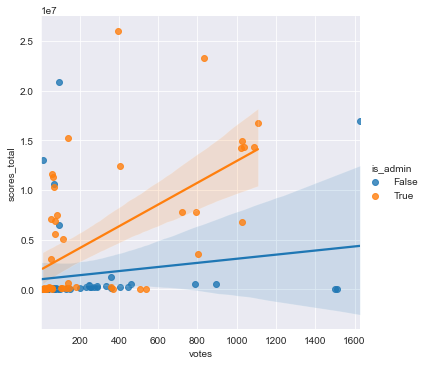

In [31]:
sns.lmplot(data=passed, x='votes', y='scores_total', hue='is_admin')
plt.show()

We can see here that the number of votes and the overall score are loosely correlated, but it does turn out that on average, proposals authored by admins gather both a larger number of votes and more SUSHIPOWAH. This might be a result of admins having more exposure to the community, as well as generally being more engaged on various channels and having closer ties with large stakeholders of governance tokens.

Even so, we can see that on a few ocasions, non-admin members were able to rally huge support for a proposal, indicating that SushiSwap has an active and decentralized community.

### Number of choices
Having a greater number of choices does not seem like it leads to greater participation. In fact, there certainly is a threshold that we can observe at 5 options, indicating that greater variety of choice means you can also address a greater audience.

However, having 3 options to choose from seems to be the sweet spot of successful proposals.

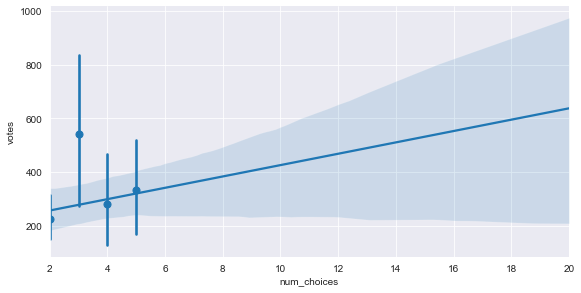

In [56]:
sns.lmplot(data=passed, x='num_choices', y='votes', height=4, aspect=2, x_bins=18)
plt.show()